In [1]:
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 2

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)


def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "MNIST",
            # 'dataset': "FashionMNIST",
            'random_class_idx': False,

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 10000,
            'per_task_memory_examples': 64,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.,
            # 'tau': 0.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            'device': torch.device('cuda:6' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha':0.001,
            'all_layer_gradient':True,
            'lambda': .1,
            'lambda_old': 0.0,
              }

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_alpha={params['alpha']}_tau={params['tau']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=MNIST/seed=2_epoch=5_lr=0.001_alpha=0.001_tau=10.0


In [2]:
from datasets import MNIST
from datasets import FashionMNIST
from datasets import CIFAR10, CIFAR100

if params['dataset'] == 'MNIST':
    benchmark = MNIST(num_tasks=params['num_tasks'],
                    per_task_memory_examples=params['per_task_memory_examples'],
                    per_task_examples = params['per_task_examples'],
                    random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'FashionMNIST':
    benchmark = FashionMNIST(num_tasks=params['num_tasks'],
                            per_task_memory_examples=params['per_task_memory_examples'],
                            per_task_examples = params['per_task_examples'],
                            random_class_idx = params['random_class_idx'])
    input_dim = (28, 28)
elif params['dataset'] == 'CIFAR10':
    benchmark = CIFAR10(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
elif params['dataset'] == 'CIFAR100':        
    benchmark = CIFAR100(num_tasks=params['num_tasks'],
                        per_task_memory_examples=params['per_task_memory_examples'],
                        per_task_examples = params['per_task_examples'],
                        random_class_idx = params['random_class_idx'])
    input_dim = (3, 32, 32)
else:
    raise NotImplementedError
class_idx = benchmark.class_idx
num_classes = len(class_idx)



[0 1 2 3 4 5 6 7 8 9]


In [3]:
from algorithms.imbalance import Heuristic2
from metrics import MetricCollector2
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
algorithm = Heuristic2(backbone, benchmark, params, requires_memory=True)
metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])

In [4]:
# from trainers import ContinualTrainer
# from trainers.fair_trainer import FairContinualTrainer2 as ContinualTrainer
from trainers.imbalance_trainer import ImbalanceContinualTrainer1 as ContinualTrainer

trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.9980288591207408, 'loss': 5.6561793753300436e-05, 'std': 0.0010900836105367517, 'EER': -1}
[2] Eval metrics for task 1 >> {'accuracy': 0.9990492672840061, 'loss': 2.9140473926884626e-05, 'std': 6.967544727143338e-05, 'EER': -1}
[3] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.98475699475471e-05, 'std': 0.0010204081632653184, 'EER': -1}
[4] Eval metrics for task 1 >> {'accuracy': 0.9989795918367347, 'loss': 1.711196741683686e-05, 'std': 0.0010204081632653184, 'EER': -1}
[5] Eval metrics for task 1 >> {'accuracy': 0.9994897959183673, 'loss': 1.3231576792455451e-05, 'std': 0.0005102040816326592, 'EER': -1}
training_task_end
---------------------------- Task 2 -----------------------
get_loss_grad done
Elapsed time(grad):51.3
losses=tensor([[2.5450e-03, 1.1380e-03, 9.3448e+00, 9.0206e+00]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(op

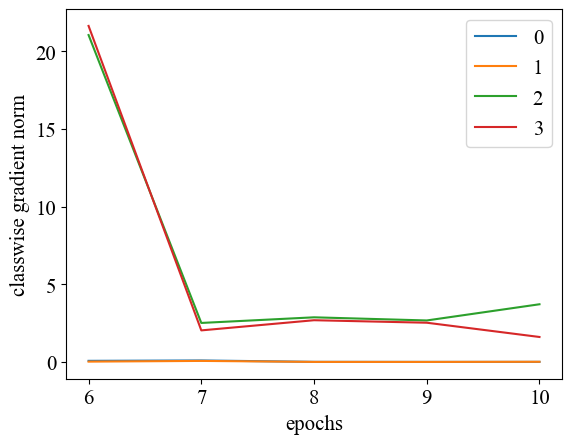

---------------------------- Task 3 -----------------------
get_loss_grad done
Elapsed time(grad):49.913
losses=tensor([[1.9808e-04, 6.2036e-04, 1.1438e-01, 5.2248e-01, 9.4623e+00, 1.1251e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):12.837
Fairness:[ 0.3116187   0.45451972  0.32926275  0.0662396  -0.42282512 -0.73881562]
Current class expected loss:[ 0.          0.          0.          0.         -2.2732189  -3.22119035]
len(updated_seq_indices)=11263
[11] Eval metrics for task 1 >> {'accuracy': 0.9534815247684977, 'loss': 0.0006972071655253146, 'std': 0.021848871707273232, 'EER': -1}
[11] Eval metrics for task 2 >> {'accuracy': 0.8371526978279222, 'loss': 0.0023940152157532245, 'std': 0.02428141069920947, 'EER': -1}
[11] Eval metrics for task 3 >> {'accuracy': 0.9524615728859379, 'loss': 0.0005838764809557061, 'std': 0.034300137908359396, 'EER': -1}
get_loss_grad done
Elapsed time(grad):50.173
losses=tensor([[0.0041, 0.0029, 0.0035, 0.0105, 0.0897

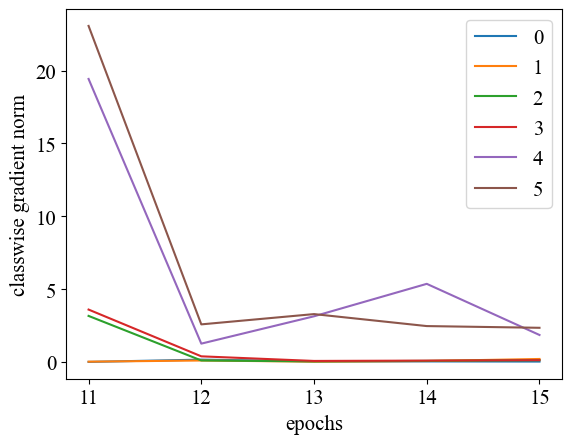

---------------------------- Task 4 -----------------------
get_loss_grad done
Elapsed time(grad):51.502
losses=tensor([[1.1769e-03, 8.1551e-04, 1.1357e-03, 1.1648e-03, 2.7699e-01, 4.9189e-01,
         1.1918e+01, 1.0035e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):18.77
Fairness:[ 0.28108231  0.31236699  0.24895892  0.21308022  0.13676752 -0.02724403
 -0.70212073 -0.46289129]
Current class expected loss:[ 0.          0.          0.          0.          0.          0.
 -3.52276469 -2.56584737]
len(updated_seq_indices)=12183
[16] Eval metrics for task 1 >> {'accuracy': 0.9221747729928975, 'loss': 0.0011064621855462978, 'std': 0.042582936258203696, 'EER': -1}
[16] Eval metrics for task 2 >> {'accuracy': 0.7920408319901757, 'loss': 0.003778416426244842, 'std': 0.029664594366413388, 'EER': -1}
[16] Eval metrics for task 3 >> {'accuracy': 0.871878795904761, 'loss': 0.0019284044983801745, 'std': 0.03443484971642019, 'EER': -1}
[16] Eval metrics for task 

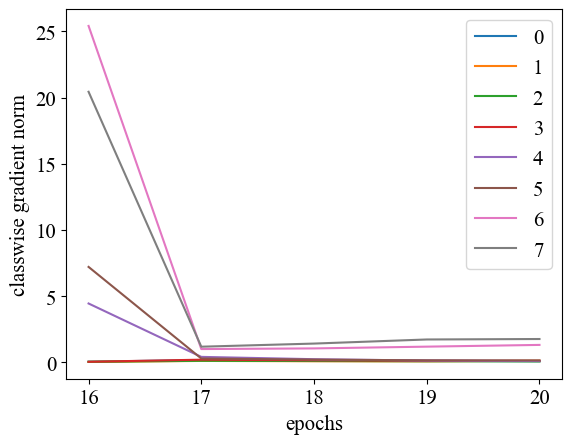

---------------------------- Task 5 -----------------------
get_loss_grad done
Elapsed time(grad):50.766
losses=tensor([[1.6672e-03, 6.2006e-03, 1.9204e-03, 2.6912e-03, 2.8333e-03, 5.1762e-03,
         4.7257e-02, 2.2315e-01, 1.1334e+01, 1.2070e+01]])
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):22.184
Fairness:[ 0.21612116  0.23423644  0.21935313  0.18256937  0.07447045  0.09676373
  0.14361812  0.05650324 -0.61128043 -0.61235533]
Current class expected loss:[ 0.          0.          0.          0.          0.          0.
  0.          0.         -3.7710459  -3.77642059]
len(updated_seq_indices)=11800
[21] Eval metrics for task 1 >> {'accuracy': 0.9106288771015014, 'loss': 0.001288188215406792, 'std': 0.025934999550481008, 'EER': -1}
[21] Eval metrics for task 2 >> {'accuracy': 0.7246939519533349, 'loss': 0.0055725868722017085, 'std': 0.053406823240463586, 'EER': -1}
[21] Eval metrics for task 3 >> {'accuracy': 0.7866667275533596, 'loss': 0.0034837784800

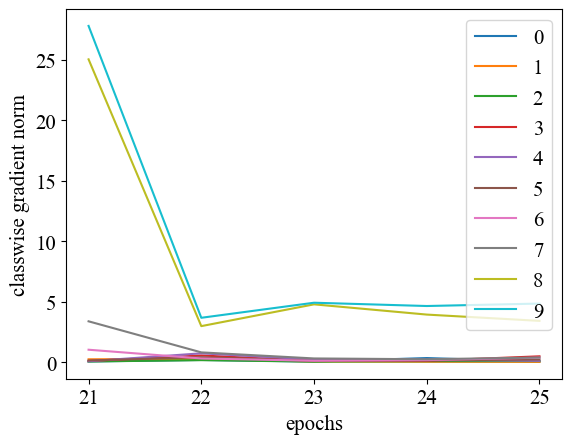

final avg-acc 0.85620657634454
final avg-forget 0.11197841676136042


In [5]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [6]:
import copy
task_weight = copy.deepcopy(algorithm.weight_all)

num_bin = 20
np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin)

def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out


binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})




task:2
task:3
task:4
task:5


In [7]:
num_bin = 20
np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin)

array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [8]:
def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out

In [9]:
binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})

task:2
task:3
task:4
task:5


In [10]:
binned_weight

{2: [{2: {1.0: 5958}, 3: {1.0: 6131}},
  {2: {0.05: 3243, 0.75: 1, 1.0: 2714}, 3: {0.05: 3452, 1.0: 2679}},
  {2: {0.05: 3512, 0.45: 1, 1.0: 2445}, 3: {0.05: 3715, 0.4: 1, 1.0: 2415}},
  {2: {0.05: 4227, 0.35: 1, 0.6: 1, 1.0: 1729},
   3: {0.05: 4349, 0.85: 1, 1.0: 1781}},
  {2: {0.05: 3436, 0.55: 1, 1.0: 2521}, 3: {0.05: 3777, 0.7: 1, 1.0: 2353}}],
 3: [{4: {1.0: 5842}, 5: {1.0: 5421}},
  {4: {0.05: 4524, 0.15: 1, 0.45: 1, 0.85: 1, 1.0: 1315},
   5: {0.05: 3927, 0.45: 1, 1.0: 1493}},
  {4: {0.05: 4965, 0.2: 2, 1.0: 875},
   5: {0.05: 4508, 0.3: 1, 0.35: 1, 0.7: 1, 1.0: 910}},
  {4: {0.05: 4937, 0.4: 1, 0.95: 1, 1.0: 903},
   5: {0.05: 4595, 0.4: 1, 1.0: 825}},
  {4: {0.05: 4925, 0.1: 1, 0.15: 1, 0.65: 1, 1.0: 914},
   5: {0.05: 4513, 0.55: 1, 1.0: 907}}],
 4: [{6: {1.0: 5918}, 7: {1.0: 6265}},
  {6: {0.05: 5706, 0.65: 1, 0.9: 1, 1.0: 210},
   7: {0.05: 6017, 0.2: 1, 0.55: 1, 0.6: 1, 0.9: 1, 0.95: 1, 1.0: 243}},
  {6: {0.05: 5718, 0.8: 2, 1.0: 198},
   7: {0.05: 5996, 0.1: 1, 0.8: 1, 0

In [11]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.999, 0.   , 0.   , 0.   , 0.   ],
       [0.988, 0.944, 0.   , 0.   , 0.   ],
       [0.965, 0.865, 0.924, 0.   , 0.   ],
       [0.927, 0.798, 0.897, 0.946, 0.   ],
       [0.906, 0.748, 0.808, 0.904, 0.915]])

In [12]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.9264346000342165

In [13]:
[np.round(x, 3) for x in metric_manager_callback.meters['EER'].compute_overall()]

[0.0, 0.022, 0.035, 0.047, 0.063]

In [14]:
np.mean(metric_manager_callback.meters['EER'].compute_overall())

0.03339097700794702

In [15]:
[np.round(x, 3) for x in metric_manager_callback.meters['std'].compute_overall()]

[0.001, 0.023, 0.042, 0.065, 0.074]

In [16]:
np.mean(metric_manager_callback.meters['std'].compute_overall())

0.040744964559896846

In [17]:
print(f"accuracy:{np.mean(metric_manager_callback.meters['accuracy'].compute_overall())}")
print(f"EER:{np.mean(metric_manager_callback.meters['EER'].compute_overall())}")
print(f"std:{np.mean(metric_manager_callback.meters['std'].compute_overall())}")


accuracy:0.9264346000342165
EER:0.03339097700794702
std:0.040744964559896846
